In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from numba import jit

visual_drift_coef = 1
visual_drift_min = 0.8
memory_drift_coef = 0.3
memory_drift_adaptive_coef_activation = 0.3
memory_drift_adaptive_coef_deactivation = 0.9
visual_drift_adaptive_coef = 0

In [107]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result


def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [108]:
# seq = '13524232514111'
# specific_seq = '13524232514111'
# random_seq = '45341323141322'
# specific_seq_changed = '13524223141322'
# specific_seq_changed_one_digit = '13524212514111'

seq = '13524232514'
specific_seq = '13524232514'
random_seq = '45341323141'
specific_seq_changed = '13524213333'
specific_seq_changed_one_digit = '13524212514'


seq_length = len(seq)

# window_sizes = [1,2,3,4,11]
window_sizes = [2,3,4,11]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)



visual_delay = 90
motor_delay = 50

diffusion = 2
threshold = 350
alpha = 0.9985
beta = 0.0005





param = [0.782587,  0.4290474,  0.7447472,  0.4274116,  0.31541915]

triggering_thresholds = [1.0, 0.3, 0.1]

In [109]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")


@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    theta = np.zeros(capacity)
    
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = param[1]
    elif capacity >= 3:
        theta[0] = param[2]
        theta[1] = param[3]
        theta[2] = param[4]

    return theta
    

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta

In [110]:
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

def calculate_IPI_from_press_time(press_times):

   return np.array([press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))])

In [111]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, triggering_thresholds, planning_strategy, visual_delay, motor_delay, alpha, beta, memory_drift_coef):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length), dtype=float)
    motor_delay_queue = np.zeros(0, dtype=float)
    current_press_planned = 0
    current_press_execed = 0

    current_memory_coef = memory_drift_coef
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta

    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]

        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef
            
            if press == current_press_planned:
                evidence[:, current_press_planned] += drifts_memory_dt[:, current_press_planned] * current_memory_coef

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
        

        triggering_check = np.array([(evidence[:, current_press_planned + i :current_press_planned + i + 1] >= threshold * triggering_thresholds[i]).any() for i in range(effective_planning_capacity)])

        if triggering_check.all() and effective_planning_capacity >0:

                
            visible_window_size -= 1
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time

            if seq[current_press_execed] == specific_seq[current_press_execed]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

            current_press_execed += 1
            
            if current_press_execed == seq_length:
                break   

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    return press_times, evidence

In [112]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3, triggering_thresholds = 3,
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay,  alpha = 0.995, beta = 0.001, memory_drift_coef = 0.7):
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.triggering_thresholds = triggering_thresholds
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta

        self.memory_drift_coef = memory_drift_coef
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
                                              self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, 
                                              self.window_size, self.planning_capacity, self.planning_param, self.triggering_thresholds,
                                              self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta, self.memory_drift_coef)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
        motor_delay_queue = np.array([], dtype=float)
        current_press_planned = 0
        current_press_execed = 0

        current_memory_coef = memory_drift_coef
        current_visual_coef = visual_drift_coef

        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        visible_window_size = 0

        press_times = np.full(seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)
        # visual_delay_passed = False

        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt
            # current_press_time += self.dt


            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
            evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

                if press == current_press_planned:
                        for finger in range(5):
                            evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt * current_memory_coef
                            evidence_over_time[finger, current_press_planned, t_index] = evidence[finger, current_press_planned]

            for press in range(0, current_press_planned):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])

            triggering_check = np.array([(evidence[:, current_press_planned + i :current_press_planned + i + 1] >= self.threshold * self.triggering_thresholds[i]).any() for i in range(effective_planning_capacity)])

            if triggering_check.all() and effective_planning_capacity >0:
                    visible_window_size -= 1
                    current_press_planned += 1
                    motor_delay_queue = np.append(motor_delay_queue, 0)
                    effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                    planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
                

            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time

                if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                    current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                    current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                print("current memory: ", current_memory_coef)
                print("current vision: ", current_visual_coef)

                current_press_execed += 1

                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
            

        for press in range(self.seq_length):
            for finger in range(5):
                axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

<timed exec>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df            F         PR(>F)
C(windowSize)               1.584496e+08     3.0   525.083160  3.591810e-237
C(condition)                9.602081e+08     1.0  9546.044588   0.000000e+00
C(windowSize):C(condition)  2.151552e+07     3.0    71.299873   2.887059e-43
Residual                    1.601345e+08  1592.0          NaN            NaN


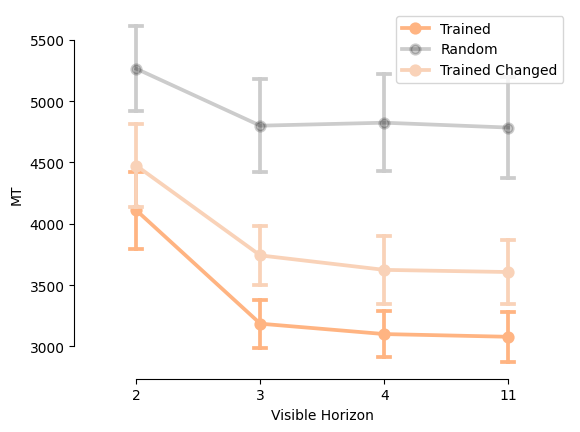

CPU times: user 33.3 s, sys: 1.2 s, total: 34.5 s
Wall time: 33.6 s


In [87]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'unchanged'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])


model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Trained', 'Random', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')

# plt.legend()
sns.despine(trim=True)
plt.show()


<timed exec>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df             F         PR(>F)
C(windowSize)               1.593083e+08     3.0    582.412030  1.933228e-255
C(condition)                9.525356e+08     1.0  10447.065679   0.000000e+00
C(windowSize):C(condition)  2.606085e+07     3.0     95.275314   1.030104e-56
Residual                    1.451543e+08  1592.0           NaN            NaN


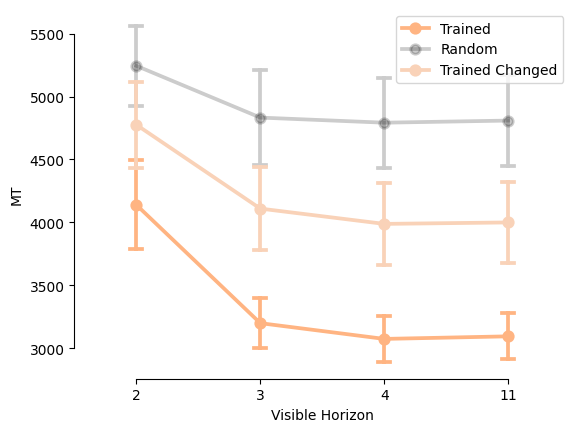

CPU times: user 32.4 s, sys: 2.71 s, total: 35.1 s
Wall time: 32.4 s


In [60]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'unchanged'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])




visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])


model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Trained', 'Random', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')

# plt.legend()
sns.despine(trim=True)
plt.show()


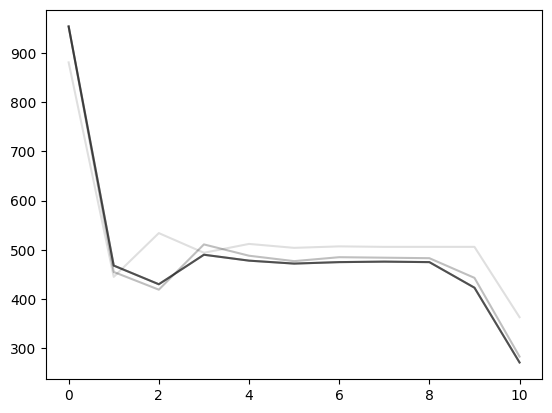

CPU times: user 1.98 s, sys: 20.2 ms, total: 2 s
Wall time: 1.96 s


In [113]:
%%time 
num_sims = 1


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = 0, threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, dt= 1, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


# plt.ylim([100,550])
# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


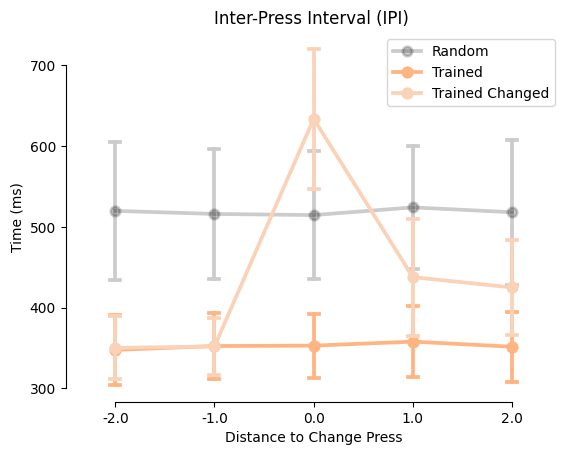

In [62]:
lookback_window = 3
change_idx = 6

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 100

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'rand'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'unchanged'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



plt.xlabel('Distance to Change Press')
plt.ylabel('Time (ms)')
plt.title(f'Inter-Press Interval (IPI) ')


sns.despine(trim=True)

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')
plt.show()


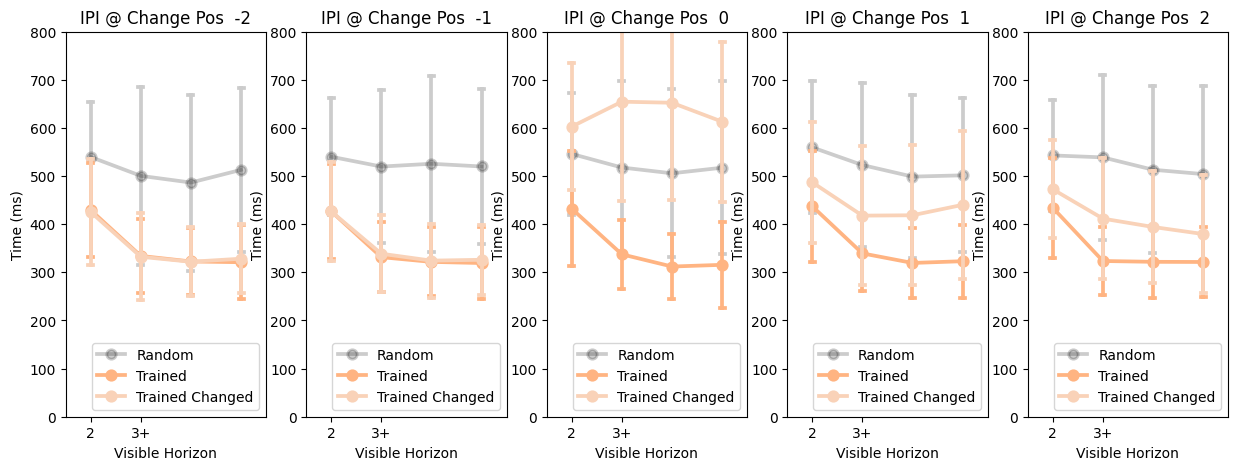

In [63]:

lookback_window = 3
change_idx = 6

fig, axs = plt.subplots(ncols=lookback_window * 2 - 1 , figsize= (15,5))

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'rand'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])







visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'unchanged'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])

    handles, _ = axs[lookback + lookback_window - 1].get_legend_handles_labels()
    labels = ['Random', 'Trained', 'Trained Changed']
    axs[lookback + lookback_window - 1].legend(handles, labels, loc = 'lower right')

    axs[lookback + lookback_window - 1].set_xticks([0,1], ['2', '3+'])
    axs[lookback + lookback_window - 1].set_xlabel('Visible Horizon')
    axs[lookback + lookback_window - 1].set_ylabel('Time (ms)')
    axs[lookback + lookback_window - 1].set_title(f'IPI @ Change Pos  {lookback}')
    axs[lookback + lookback_window - 1].set_ylim([0, 800])






# plt.xlabel('Distance to Change Press')
# plt.ylabel('Time (ms)')
# plt.title(f'Inter-Press Interval (IPI) ')


# sns.despine(trim=True)

# # legend labels
# handles, _ = plt.gca().get_legend_handles_labels()
# labels = ['Random', 'Trained', 'Trained Changed']
# plt.legend(handles, labels, loc='upper right')
# plt.show()


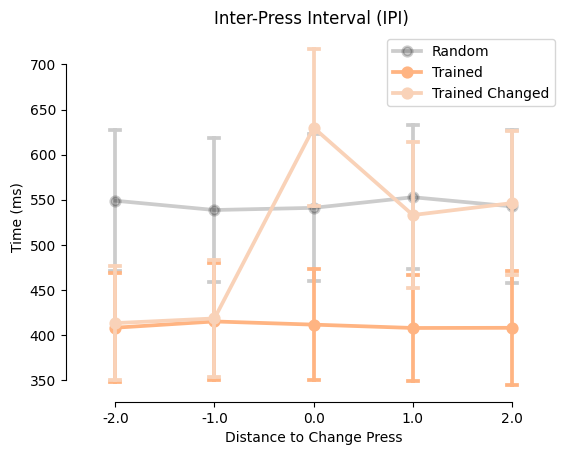

In [32]:
lookback_window = 3
change_idx = 6

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'rand'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'unchanged'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef, triggering_thresholds = triggering_thresholds)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



plt.xlabel('Distance to Change Press')
plt.ylabel('Time (ms)')
plt.title(f'Inter-Press Interval (IPI) ')


sns.despine(trim=True)

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')
plt.show()


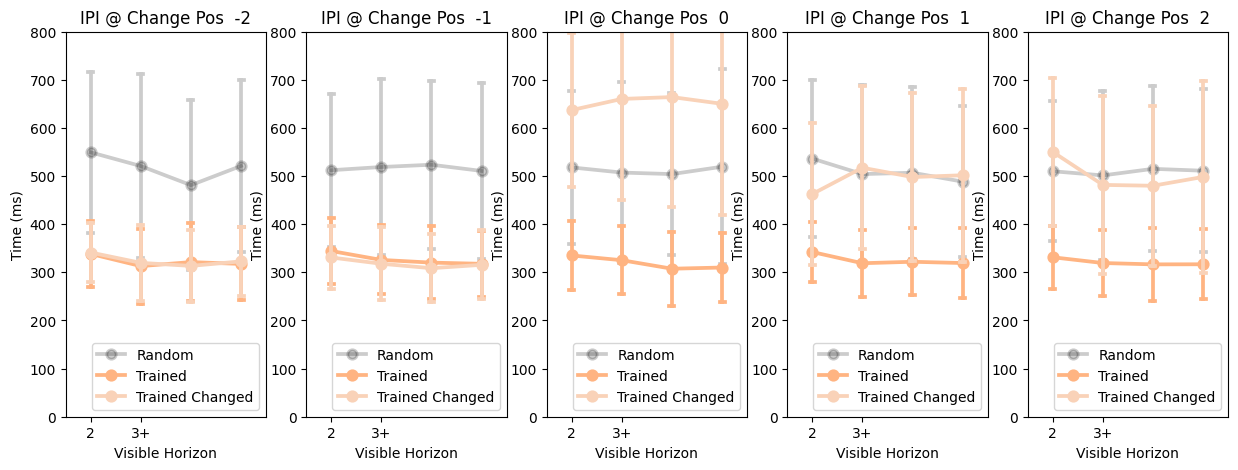

In [ ]:

lookback_window = 3
change_idx = 6

fig, axs = plt.subplots(ncols=lookback_window * 2 - 1 , figsize= (15,5))

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'rand'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])







visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'unchanged'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])




visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])

    handles, _ = axs[lookback + lookback_window - 1].get_legend_handles_labels()
    labels = ['Random', 'Trained', 'Trained Changed']
    axs[lookback + lookback_window - 1].legend(handles, labels, loc = 'lower right')

    axs[lookback + lookback_window - 1].set_xticks([0,1], ['2', '3+'])
    axs[lookback + lookback_window - 1].set_xlabel('Visible Horizon')
    axs[lookback + lookback_window - 1].set_ylabel('Time (ms)')
    axs[lookback + lookback_window - 1].set_title(f'IPI @ Change Pos  {lookback}')
    axs[lookback + lookback_window - 1].set_ylim([0, 800])






# plt.xlabel('Distance to Change Press')
# plt.ylabel('Time (ms)')
# plt.title(f'Inter-Press Interval (IPI) ')


# sns.despine(trim=True)

# # legend labels
# handles, _ = plt.gca().get_legend_handles_labels()
# labels = ['Random', 'Trained', 'Trained Changed']
# plt.legend(handles, labels, loc='upper right')
# plt.show()


current memory:  0.02999999999999997
current vision:  1
current memory:  0.0029999999999999957
current vision:  1
current memory:  0.0002999999999999995
current vision:  1
current memory:  2.9999999999999916e-05
current vision:  1
current memory:  2.9999999999999916e-06
current vision:  1
current memory:  2.9999999999999925e-07
current vision:  1
current memory:  2.9999999999999925e-08
current vision:  1
current memory:  2.9999999999999905e-09
current vision:  1
current memory:  2.9999999999999896e-10
current vision:  1
current memory:  2.9999999999999896e-11
current vision:  1
current memory:  2.9999999999999896e-12
current vision:  1


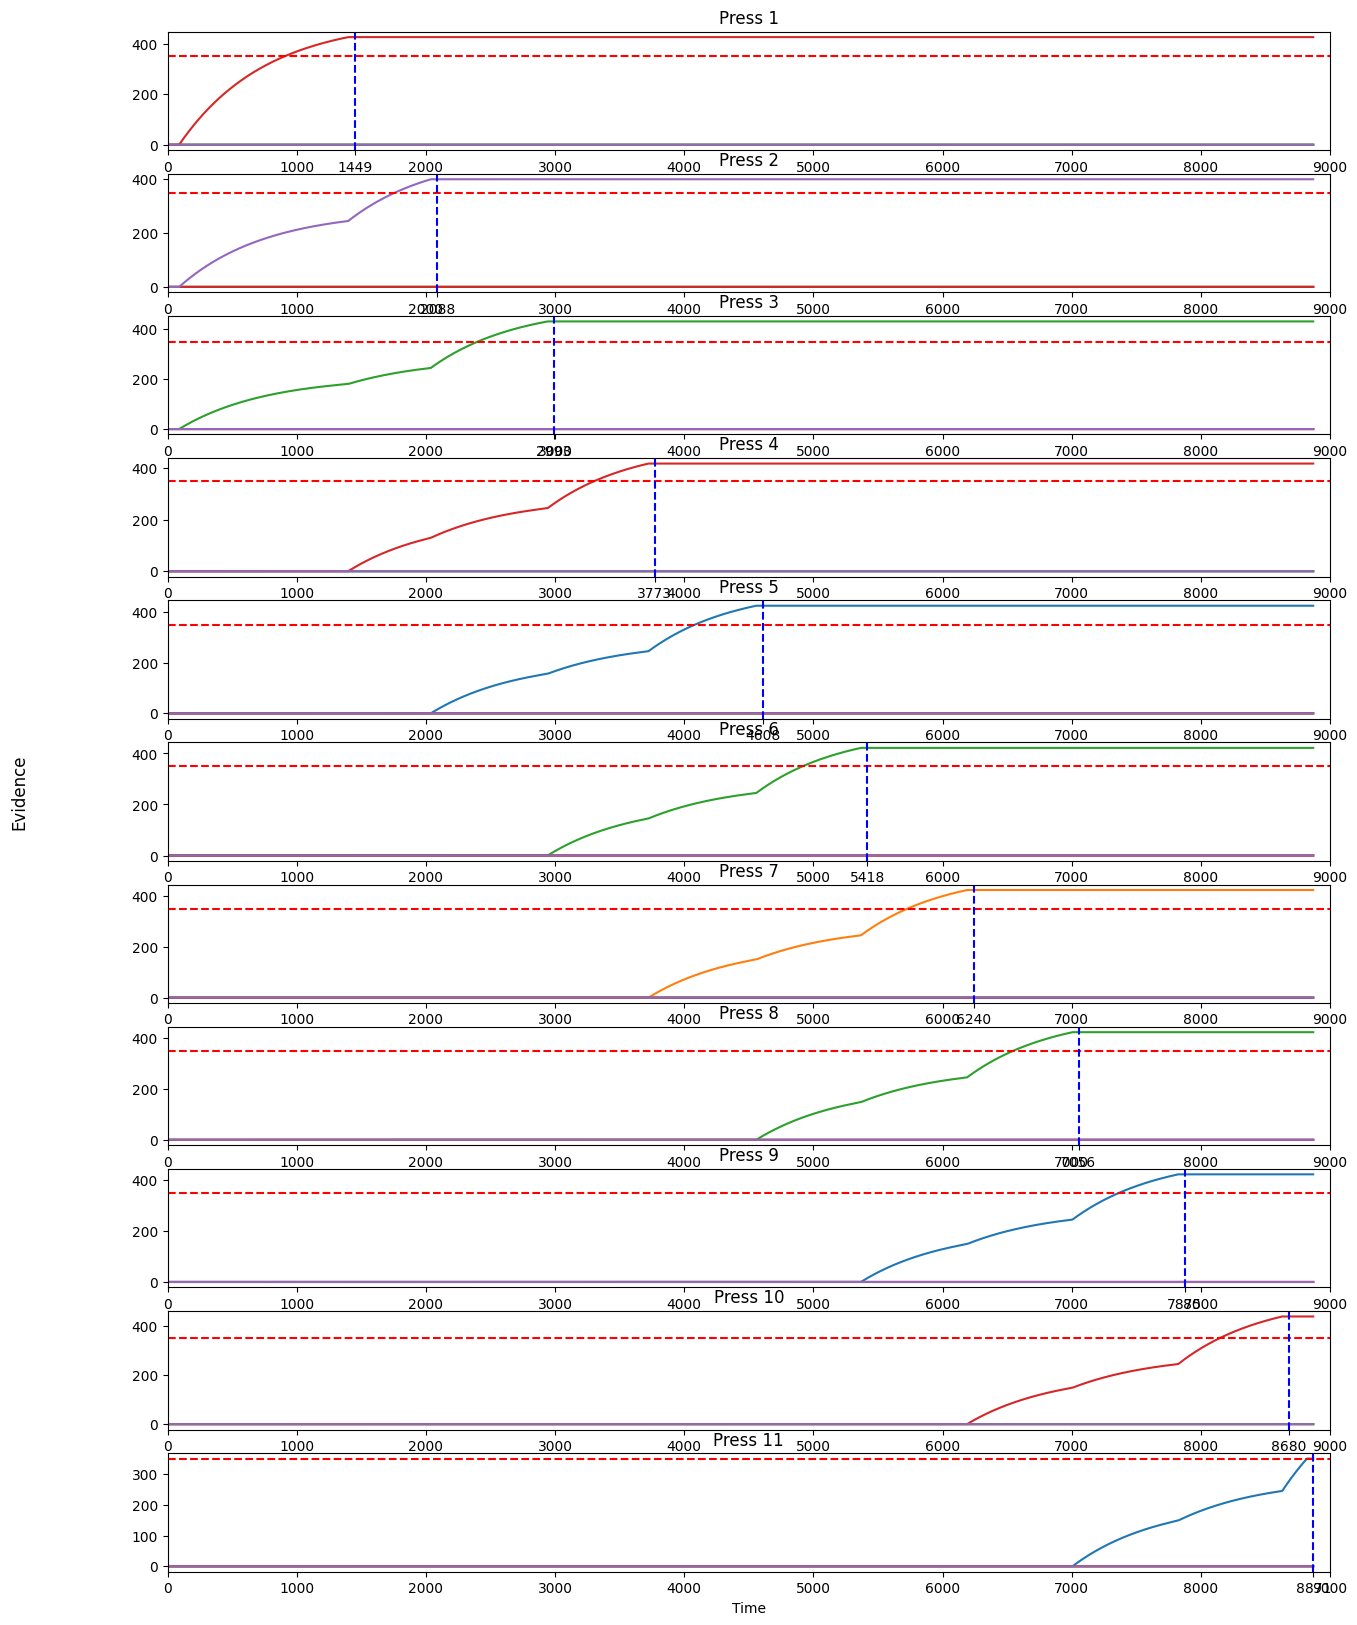

In [104]:
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
                                      diffusion = 0, threshold = threshold, visual_delay=visual_delay, motor_delay= motor_delay,
                                      planning_capacity=3, planning_param=param, 
                                      seq_length=seq_length, alpha = alpha, beta = beta, window_size=11, memory_drift_coef=memory_drift_coef, 
                                      triggering_thresholds=triggering_thresholds)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()